In [ ]:
"""Evaluation for the CGAN 2D."""

from __future__ import annotations
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

from engiopt import metrics
from engibench.utils.all_problems import BUILTIN_PROBLEMS
import torch as th

from engiopt.cgan_2d import Generator
import wandb
import numpy as np




problem_id: str = "beams2d"
#problem_id: str = "heatconduction2d"
"""Problem identifier."""
seed: int = 1
"""Random seed."""
wandb_project: str = "engiopt"
"""Wandb project name."""
wandb_entity: str | None = None
"""Wandb entity name."""
n_samples: int = 5
"""Number of generated samples."""
sigma: float = 10.0
"""Kernel bandwidth for mmd and dpp"""



problem = BUILTIN_PROBLEMS[problem_id]()
problem.reset(seed=seed)

if th.backends.mps.is_available():
    device = th.device("mps")
elif th.cuda.is_available():
    device = th.device("cuda")
else:
    device = th.device("cpu")
    
    
    
    


In [2]:
test_ds = problem.dataset["test"] 

# Extract conditions
condition_keys = [key for key, _ in problem.conditions]
conditions_ds = test_ds.select_columns(condition_keys)

# Sample conditions at random indices
selected_indices = np.random.choice(len(test_ds), n_samples, replace=True)
sampled_conditions = conditions_ds.select(selected_indices)

# Convert dict_values to a list of lists
conditions_list = list(sampled_conditions[:].values())

# Transpose the list to align the data correctly
conditions_list = list(map(list, zip(*conditions_list)))

# Create a tensor from the list
conditions_tensor = th.tensor(conditions_list, dtype=th.float32, device=device)



In [3]:
# Restores the pytorch model from wandb
if wandb_entity is not None:
    artifact_path = f"{wandb_entity}/{wandb_project}/{problem_id}_cgan_2d_generator:seed_{seed}"
else:
    artifact_path = f"{wandb_project}/{problem_id}_cgan_2d_generator:seed_{seed}"

    
api = wandb.Api()
artifact = api.artifact(artifact_path, type="model")
run = artifact.logged_by()
artifact_dir = artifact.download()


ckpt_path = os.path.join(artifact_dir, "generator.pth")
ckpt = th.load(ckpt_path)
model = Generator(latent_dim=run.config["latent_dim"], 
                  n_conds=len(problem.conditions), 
                  design_shape=problem.design_space.shape)
model.load_state_dict(ckpt["generator"])
model.eval()  # Set to evaluation mode
model.to(device)


# Sample noise as generator input
z = th.randn((n_samples, run.config["latent_dim"]), device=device, dtype=th.float)

# Generate a batch of designs
gen_designs = model(z, conditions_tensor)
gen_designs_np = gen_designs.detach().cpu().numpy()


gen_designs_np = np.clip(gen_designs_np, 1e-3, 1)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact beams2d_cgan_2d_generator:seed_1, 66.78MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Obj_GAN_output: [4.44231512e+08] Obj_GAN_optimized: [56.77096909]
Obj_Dataset: [57.49379178] Obj_Dataset_optimized: [57.79249377]


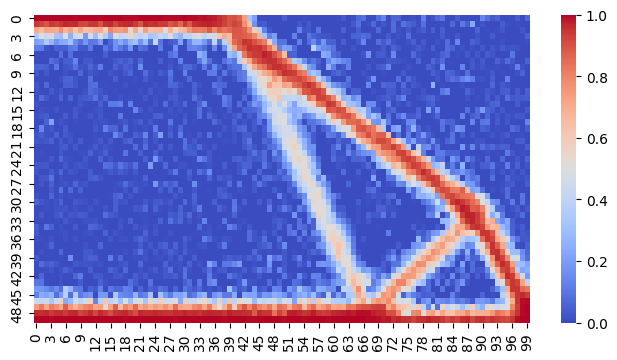

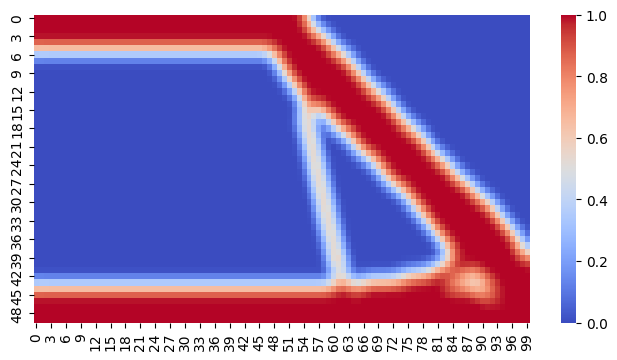

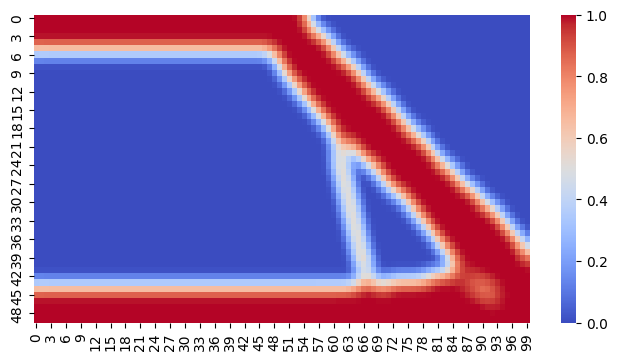

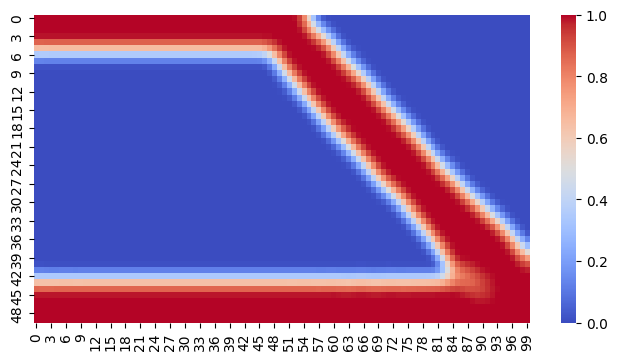

In [4]:
i = 0

# Load/Simulate GAN Warmstart Design
problem.render(gen_designs_np[i])
GAN_opt_design, GAN_opt_history = problem.optimize(gen_designs_np[i], sampled_conditions[i])
problem.render(GAN_opt_design)

# Load/Simulate Dataset Design
problem.render(np.array(test_ds['optimal_design'][selected_indices[i]]))
opt_design, opt_history = problem.optimize(np.array(test_ds['optimal_design'][selected_indices[i]]), sampled_conditions[i])
problem.render(opt_design)

print('Obj_GAN_output:', problem.simulate(gen_designs_np[i]), 'Obj_GAN_optimized:', problem.simulate(opt_design))
print('Obj_Dataset:', problem.simulate(np.array(test_ds['optimal_design'][selected_indices[i]])), 'Obj_Dataset_optimized:', problem.simulate(GAN_opt_design))

In [5]:
# Metrics
print('MMD:', metrics.mmd(gen_designs_np, np.array(test_ds['optimal_design'])[selected_indices]), sigma=sigma)
print('DPP:', metrics.dpp_diversity(gen_designs_np), sigma=sigma)



MMD: 0.399990697174569
DPP: 1.0000050000099996


In [6]:
# Compute the average instnataneous and cumulative optimality gap for the dataset of generated designs
COG_list = []
IOG_list = []
FOG_list = []
for i in range(n_samples):
    opt_design, opt_history = problem.optimize(gen_designs_np[i], sampled_conditions[i])
    reference_optimum = problem.simulate(np.array(test_ds['optimal_design'][selected_indices[i]]))
    opt_history_gaps = metrics.optimality_gap(opt_history, reference_optimum)

    IOG_list.append(opt_history_gaps[0])
    COG_list.append(np.sum(opt_history_gaps))
    FOG_list.append(opt_history_gaps[-1])


average_IOG = np.mean(IOG_list)
average_COG = np.mean(COG_list)
average_FOG = np.mean(FOG_list)

print('Average COG:', average_COG, 'Average IOG:', average_IOG, 'Average FOG:', average_FOG)



Average COG: 199957854.7610386 Average IOG: 199274976.64759916 Average FOG: 0.057160430683885724


In [7]:
metrics = metrics.metrics(problem, gen_designs_np, np.array(test_ds['optimal_design'])[selected_indices], sampled_conditions, sigma=sigma)
metrics

{'IOG': np.float64(199274976.64759916),
 'COG': np.float64(199957854.7610386),
 'FOG': np.float64(0.057160430683885724),
 'mmd': np.float64(0.399990697174569),
 'dpp': np.float64(1.0000050000099996)}